# Breast Cancer Dataset


In [12]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [14]:
data = pd.read_csv('./dataset.csv')
data.drop('id',axis=1,inplace=True)
data.drop('Unnamed: 32',axis=1,inplace=True)
data['diagnosis'] = data['diagnosis'].map({'M':1,'B':0})
datas = pd.DataFrame(preprocessing.scale(data.iloc[:,1:32]))
datas.columns = list(data.iloc[:,1:32].columns)
datas['diagnosis'] = data['diagnosis']

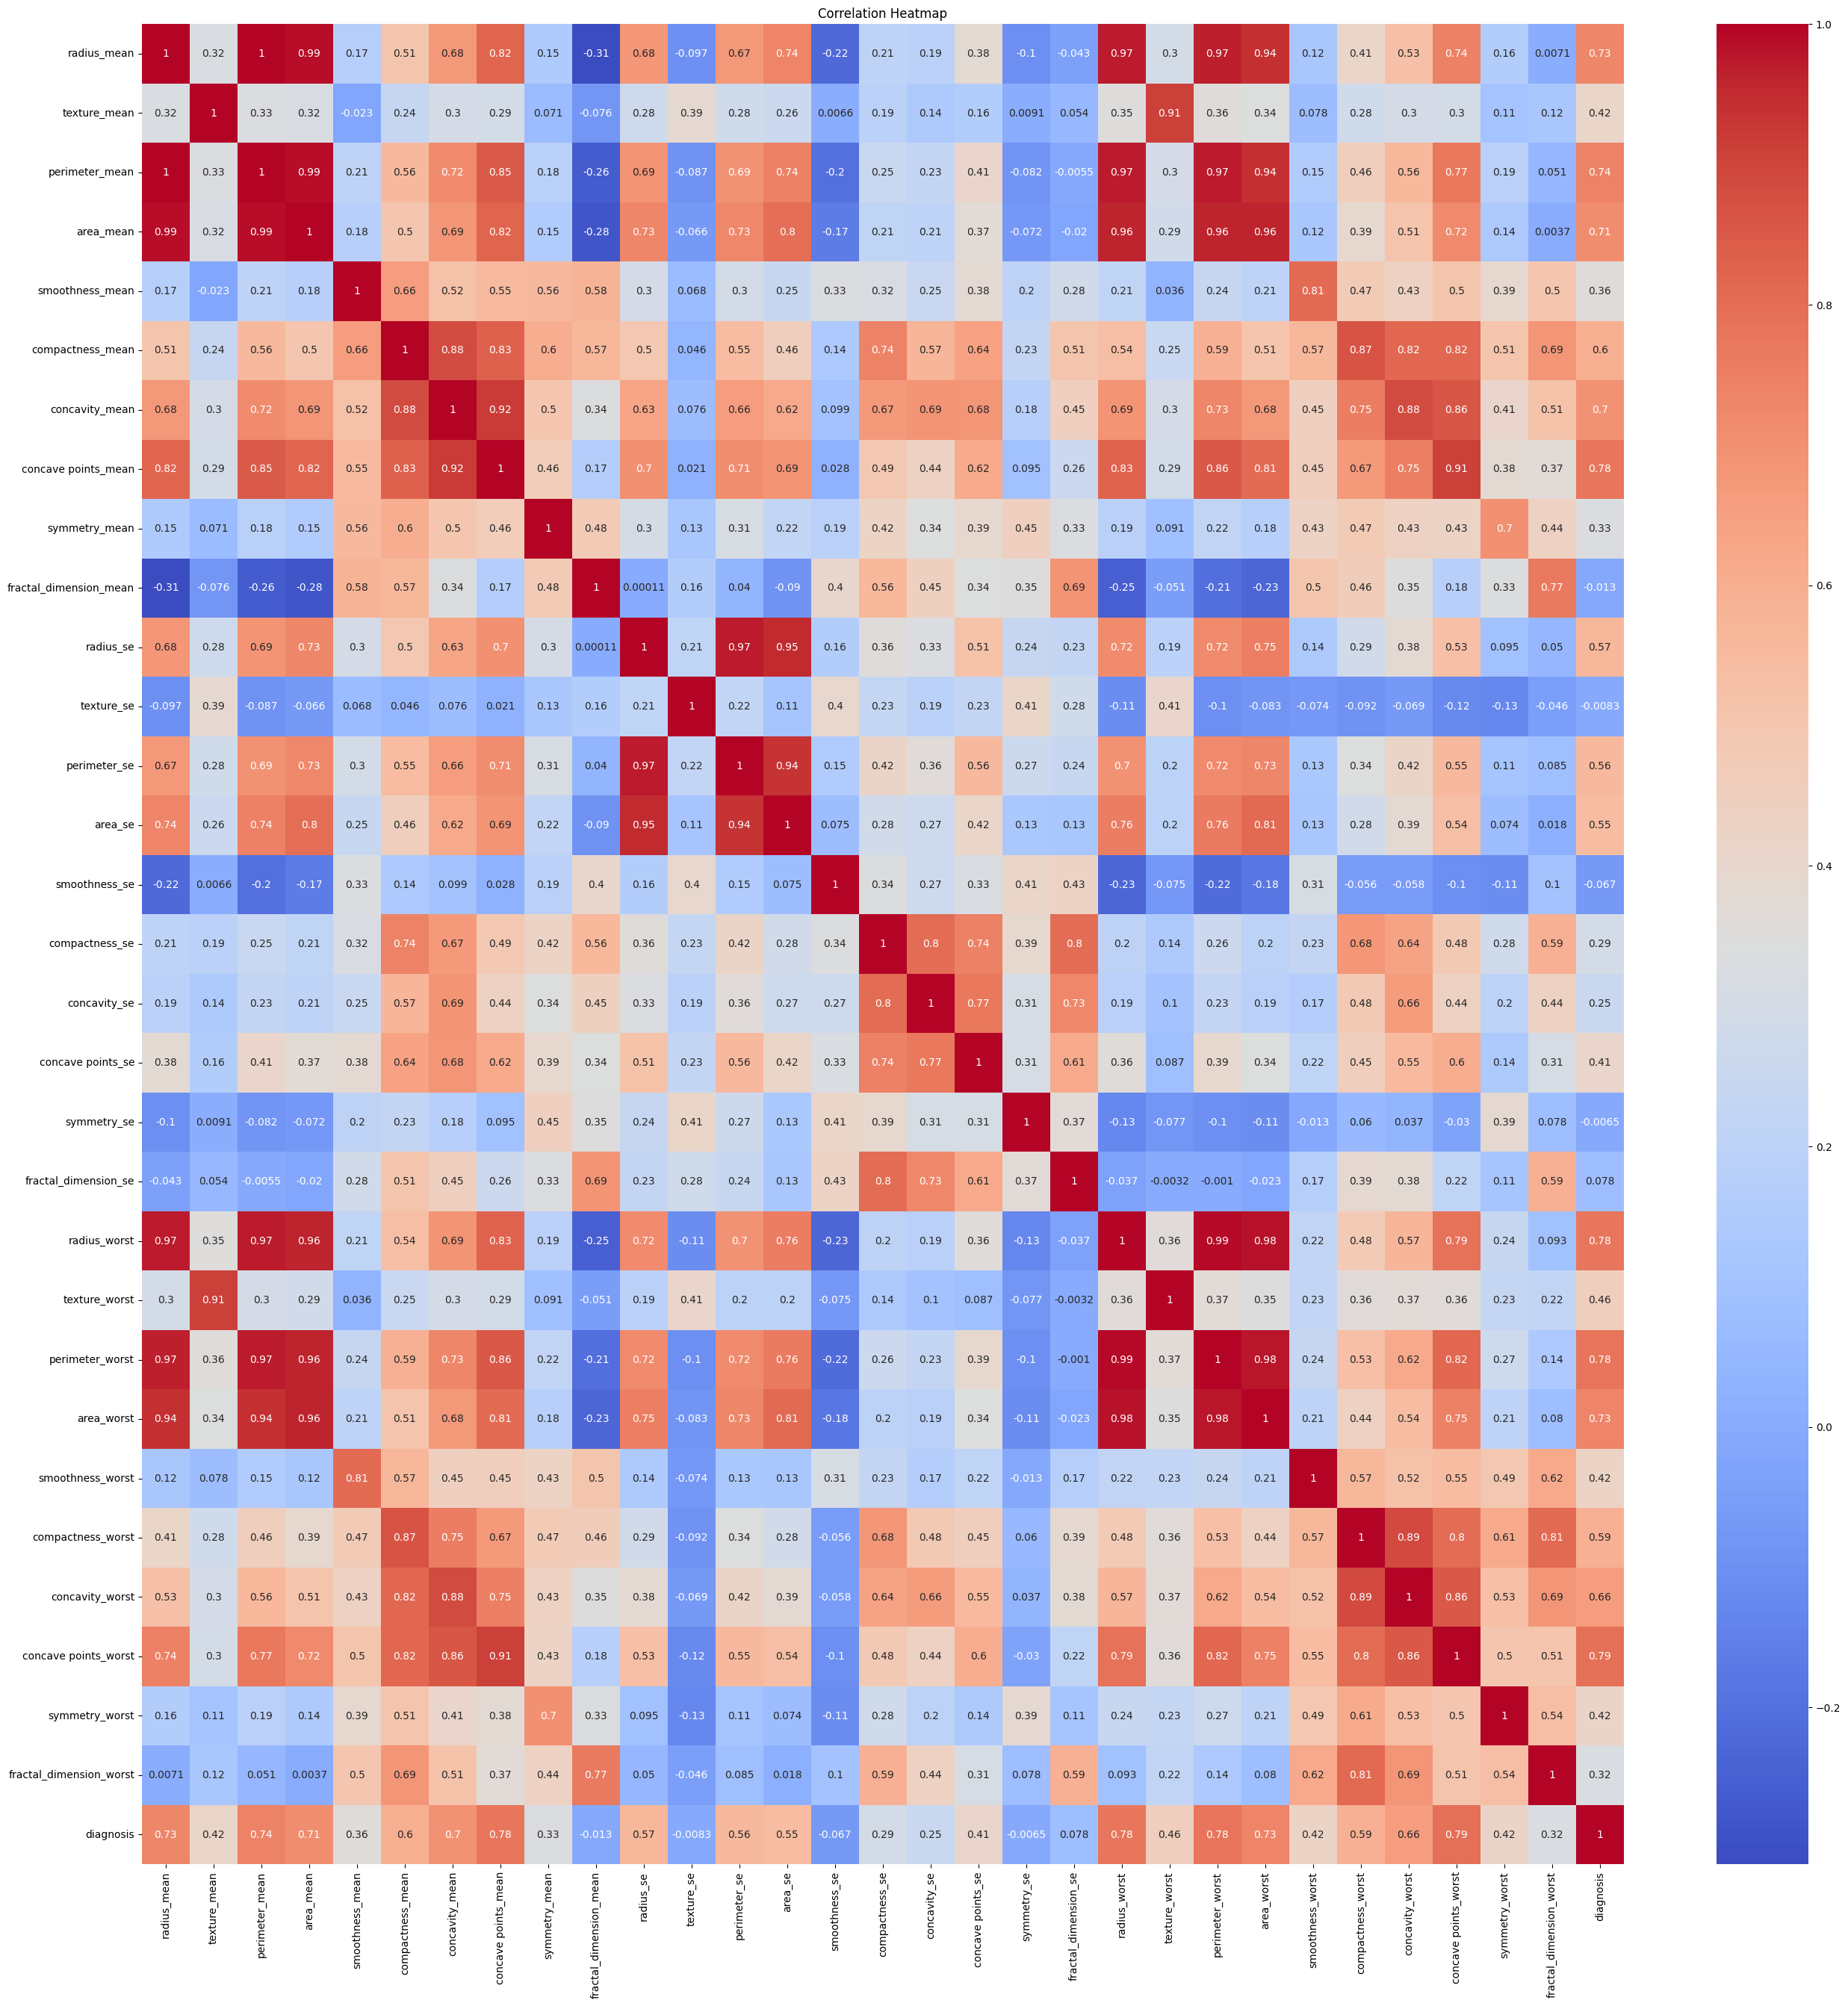

In [15]:
plt.figure(figsize=(32,32))
sns.heatmap(datas.corr(), cmap='coolwarm', annot=True)
plt.title('Correlation Heatmap')
plt.show()

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    int64  
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se                  5

In [17]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn import metrics

predictors = datas.columns[2:11]
target = "diagnosis"
X = datas.loc[:,predictors]
y = np.ravel(data.loc[:,[target]])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print ('Data train : %i || Data test : %i' % (X_train.shape[0],X_test.shape[0]) )

Data train : 398 || Data test : 171


## Decision Tree

Accuracy 92.4


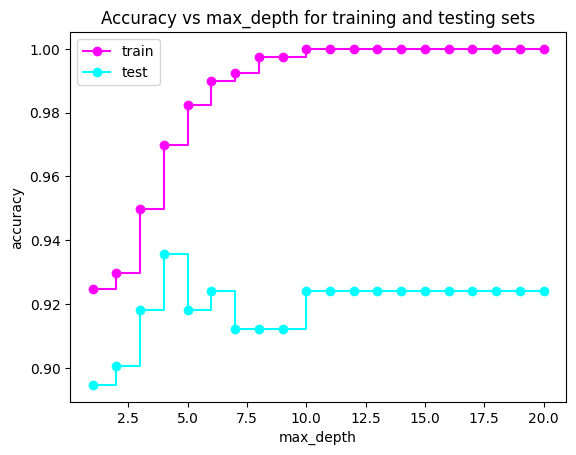

In [22]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

predictors = datas.columns[2:11]
target = "diagnosis"
X = datas.loc[:, predictors]
y = datas[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Accuracy %s" % round(acc*100,2))
depth_range = range(1, 21)
train_scores = []
test_scores = []
for depth in depth_range:
    clf = DecisionTreeClassifier(max_depth=depth, random_state=42)
    clf.fit(X_train, y_train)
    train_scores.append(clf.score(X_train, y_train))
    test_scores.append(clf.score(X_test, y_test))

fig, ax = plt.subplots()
ax.set_xlabel("max_depth")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs max_depth for training and testing sets")
ax.plot(depth_range, train_scores, marker="o", label="train", drawstyle="steps-post",color='magenta')
ax.plot(depth_range, test_scores, marker="o", label="test", drawstyle="steps-post",color='cyan')
ax.legend()
plt.show()

## Random Forest

Accuracy 92.22


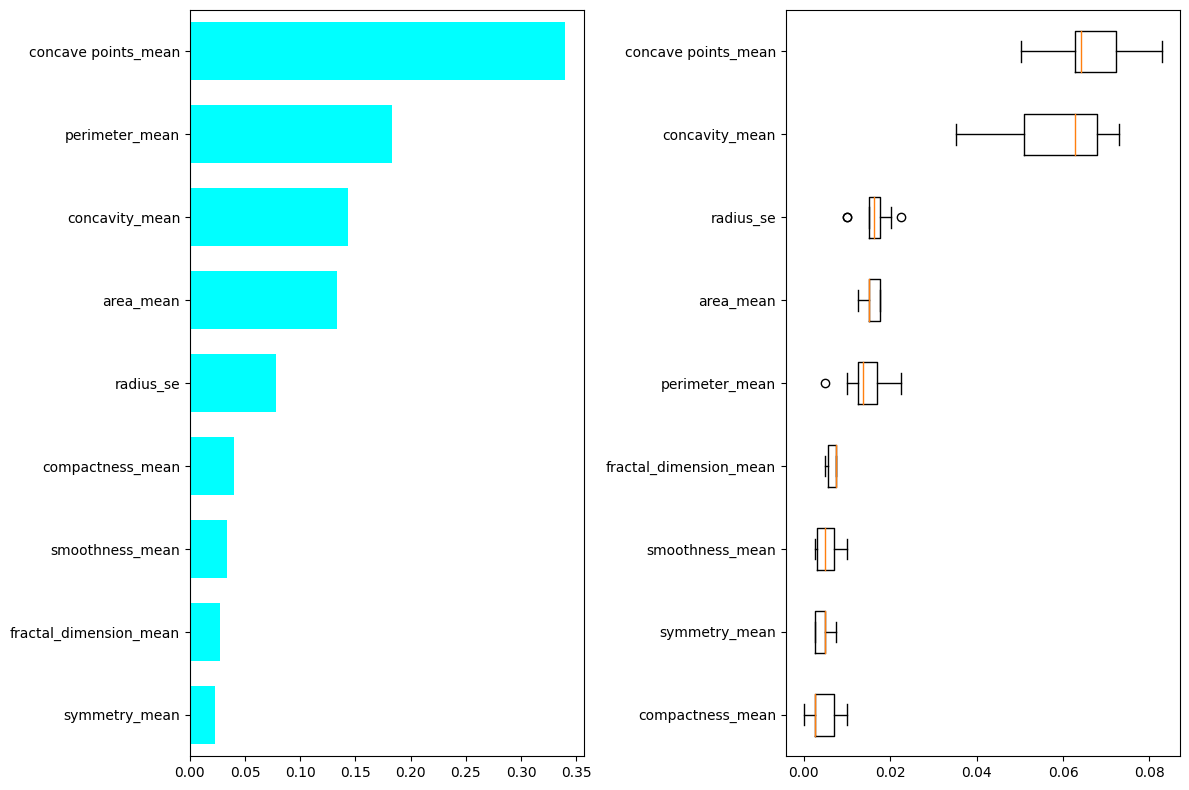

In [25]:
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_train, y_train)
scores = cross_val_score(rf, X_train, y_train, scoring='accuracy', cv=10).mean()
print("Accuracy %s" % round(scores*100,2))
result = permutation_importance(rf, X_train, y_train, n_repeats=10, random_state=42)
perm_sorted_idx = result.importances_mean.argsort()
tree_importance_sorted_idx = np.argsort(rf.feature_importances_)
tree_indices = np.arange(0, len(rf.feature_importances_)) + 0.5
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.barh(tree_indices, rf.feature_importances_[tree_importance_sorted_idx], height=0.7,color='cyan')
ax1.set_yticks(tree_indices)
ax1.set_yticklabels(X_train.columns[tree_importance_sorted_idx])
ax1.set_ylim((0, len(rf.feature_importances_)))
ax2.boxplot(
    result.importances[perm_sorted_idx].T,
    vert=False,
    labels=X_train.columns[perm_sorted_idx],
)
fig.tight_layout()
plt.show()

## Self-Training

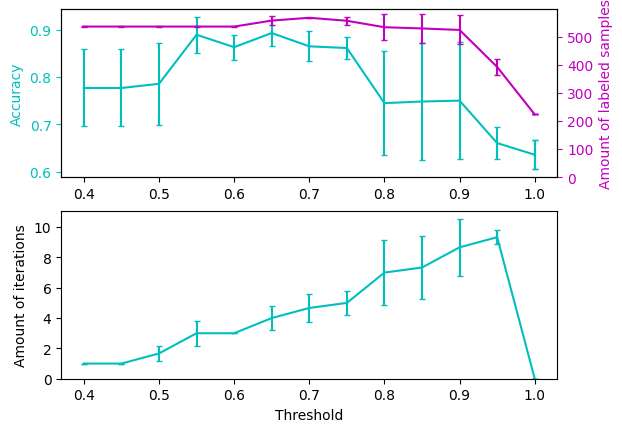

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle

n_splits = 3

X, y = datasets.load_breast_cancer(return_X_y=True)
X, y = shuffle(X, y, random_state=42)
y_true = y.copy()
y[50:] = -1
total_samples = y.shape[0]

base_classifier = SVC(probability=True, gamma=0.001, random_state=42)

x_values = np.arange(0.4, 1.05, 0.05)
x_values = np.append(x_values, 0.99999)
scores = np.empty((x_values.shape[0], n_splits))
amount_labeled = np.empty((x_values.shape[0], n_splits))
amount_iterations = np.empty((x_values.shape[0], n_splits))

for i, threshold in enumerate(x_values):
    self_training_clf = SelfTrainingClassifier(base_classifier, threshold=threshold)

    # We need manual cross validation so that we don't treat -1 as a separate
    # class when computing accuracy
    skfolds = StratifiedKFold(n_splits=n_splits)
    for fold, (train_index, test_index) in enumerate(skfolds.split(X, y)):
        X_train = X[train_index]
        y_train = y[train_index]
        X_test = X[test_index]
        y_test = y[test_index]
        y_test_true = y_true[test_index]

        self_training_clf.fit(X_train, y_train)

        # The amount of labeled samples that at the end of fitting
        amount_labeled[i, fold] = (
            total_samples
            - np.unique(self_training_clf.labeled_iter_, return_counts=True)[1][0]
        )
        # The last iteration the classifier labeled a sample in
        amount_iterations[i, fold] = np.max(self_training_clf.labeled_iter_)

        y_pred = self_training_clf.predict(X_test)
        scores[i, fold] = accuracy_score(y_test_true, y_pred)


ax1 = plt.subplot(211)
ax1.errorbar(
    x_values, scores.mean(axis=1), yerr=scores.std(axis=1), capsize=2, color="c"
)
ax1.set_ylabel("Accuracy", color="c")
ax1.tick_params("y", colors="c")

ax2 = ax1.twinx()
ax2.errorbar(
    x_values,
    amount_labeled.mean(axis=1),
    yerr=amount_labeled.std(axis=1),
    capsize=2,
    color="m",
)
ax2.set_ylim(bottom=0)
ax2.set_ylabel("Amount of labeled samples", color="m")
ax2.tick_params("y", colors="m")

ax3 = plt.subplot(212, sharex=ax1)
ax3.errorbar(
    x_values,
    amount_iterations.mean(axis=1),
    yerr=amount_iterations.std(axis=1),
    capsize=2,
    color="c",
)
ax3.set_ylim(bottom=0)
ax3.set_ylabel("Amount of iterations")
ax3.set_xlabel("Threshold")

plt.show()